# BACKTESTING & ANALYSIS OF THE PRICE-FROM-HIGH FACTOR

Libraries for import:

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

from scipy.stats import spearmanr
from statsmodels.tsa.stattools import acf

import os

import matplotlib.pyplot as plt

%matplotlib inline

### OUTLINE

1. IMPORT AND CLEAN DATA
1. EXAMINE AND PLOT THE DISTRIBUTION OF THE FACTOR
    - Visualize factor scores and distribution
    - Normalize factor score (e.g. Z-Score or Percentile).
2. SELECT THE OPTIMAL WINDOW FOR THE FACTOR SCORE
    - Analyze rolling windows for price/ high price factor.
2. QUANTILES ROLLING WINDOW BACKTEST (LONG/SHORT APPROCAH)
    - Assign security factor scores into quantiles.
    - Compute and visualize quantile risk and return statistics. 
3. INFORMATION COEFFICIENT (IC): SPEARMAN RANK
4. CROSS-SECTIONAL (UNIVARIATE) REGRESSION
5. FACTOR TURNOVER AND DECAY  


### IMPORT AND CLEAN DATA

RETURNS DATA

In [2]:
file_loc = ""
RETURNS_IMPORT = pd.read_excel("202407_FS_M_Price_Ret.xlsx", sheet_name="Values", index_col = 0, parse_dates=True)
RETURNS = RETURNS_IMPORT.dropna(how="all", axis = 1)
RETURNS.columns = "C"+ RETURNS.columns.values
RETURNS = (RETURNS/100).resample("ME").last()
RETURNS

,C69344F106,C711030106,C000886309,C63934E108,C254067101,C171779309,C654086107,C670006105,C589433101,C427056106,...,C86800U104,C243537107,C219948106,C83444M101,C36828A101,C92840M102,C504922105,C22788C105,C48251W104,C380237107
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-31,0.226978,0.061306,0.136201,-0.049616,0.043513,0.346801,0.040448,0.103058,0.046236,0.036283,...,NaN,0.156046,NaN,NaN,NaN,NaN,0.089136,NaN,NaN,NaN
2006-02-28,0.079281,-0.013702,-0.001577,0.079044,-0.047490,0.005000,0.049633,-0.023614,0.006026,0.011956,...,NaN,0.061698,NaN,NaN,NaN,NaN,-0.009207,NaN,NaN,NaN
2006-03-31,0.203722,-0.029147,0.010664,-0.060307,0.055533,0.296020,-0.078500,-0.192429,0.012707,0.164557,...,NaN,0.195870,NaN,NaN,NaN,NaN,0.006367,NaN,NaN,NaN
2006-04-30,0.011391,0.019360,-0.125049,-0.043510,0.001536,-0.214971,0.001264,0.070312,-0.110952,0.029710,...,NaN,0.053034,NaN,NaN,NaN,NaN,-0.023598,NaN,NaN,NaN
2006-05-31,-0.224457,0.032755,-0.199643,0.007581,0.043712,0.051345,0.034587,-0.059611,0.009073,0.088670,...,NaN,-0.169361,NaN,NaN,NaN,NaN,0.039580,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,NaN,NaN,NaN,NaN,0.137222,-0.132152,NaN,NaN,NaN,NaN,...,0.166155,0.050994,0.104809,NaN,NaN,0.277044,0.012186,-0.010983,0.023611,0.039685
2024-04-30,NaN,NaN,NaN,NaN,-0.071347,-0.065116,NaN,NaN,NaN,NaN,...,-0.149728,-0.130453,-0.020743,-0.065277,0.124022,0.088873,-0.078229,-0.087495,-0.074667,0.031176
2024-05-31,NaN,NaN,NaN,NaN,0.021370,0.041964,NaN,NaN,NaN,NaN,...,-0.086504,0.336543,-0.114086,-0.087217,0.144363,0.306435,-0.032080,0.072230,0.104975,0.140954


BENCHMARK DATA

In [3]:
BK = yf.Ticker("SPY").history(start = "2005-11-30", end = "2024-08-31")["Close"].resample("ME").last()
BK_PCT = BK.pct_change()
BK_PCT.index = BK_PCT.index.tz_localize(None)

We will need to calculate synthetic prices based on returns securities return data:

In [4]:
SYNTHETIC_PRICE = (RETURNS + 1).cumprod()
SYNTHETIC_PRICE.loc["2005-12-31",:] = 1 # our starting price is 1. 
SYNTHETIC_PRICE = SYNTHETIC_PRICE.sort_index()

### EXAMINE AND PLOT THE DISTRIBUTION OF THE FACTOR

We will use a rolling monthly window of 12: the ratio of the current price respective to its 12-month high. This number will range between 0 and 1, where one would mean that the stock is setting a new 12-month high.  

Factor Score = Price / Price 12-Month High

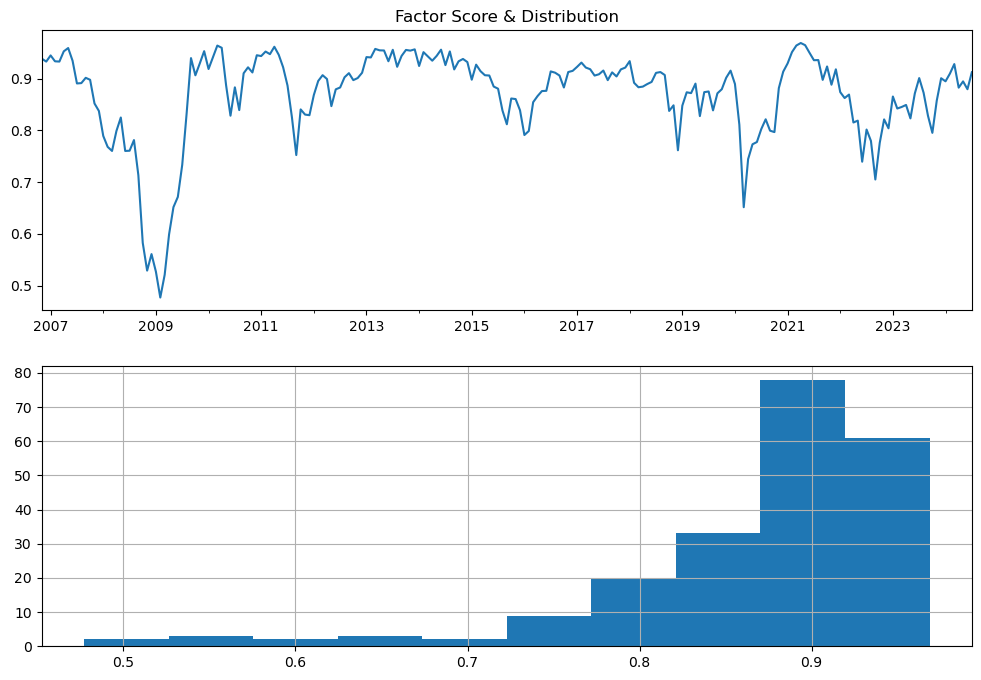

In [5]:
window = 12

CUMMAX = SYNTHETIC_PRICE.rolling(window).max()
FACTOR_PFH = SYNTHETIC_PRICE / CUMMAX
FACTOR_PFH = FACTOR_PFH.dropna(how="all")

fig, ax = plt.subplots(2,1, figsize=(12,8))
FACTOR_PFH.mean(axis = 1).plot(title = "Factor Score & Distribution", ax = ax[0], xlabel="")
FACTOR_PFH.mean(axis=1).hist(ax = ax[1])
plt.show()

Factor scores are concentrated to the right. This makes sense since markets typically move higher, so securities will be near their 12-month high. The exceptions will be market drawdowns like the one seen during the 2007-2009 recession, when a large portion of securities were below their 12-month high. We will need to normalize the data.

NORMALIZE DATA:

We will use the factors' percentile rank. This will give us a uniform distribution, where the factor percentile will range between 0 and 1 with a mean of 0.5. 

Below is an example of Apple's (Ticker: AAPL) stock factor percentile.

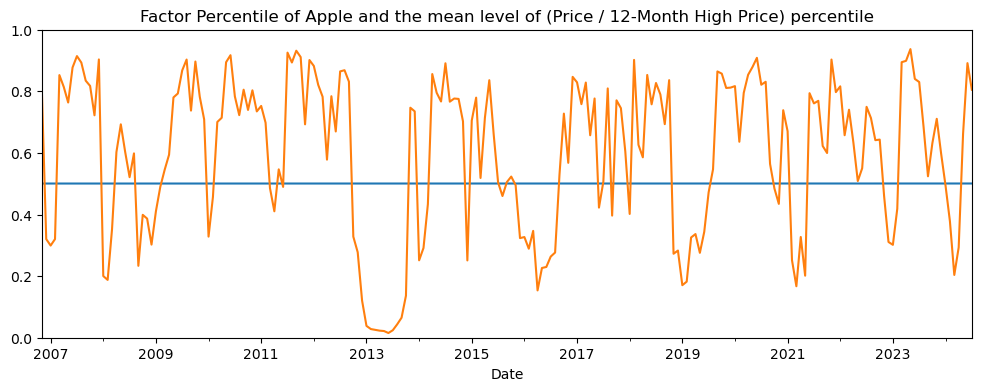

In [6]:
FACTOR_PFH_PERCENTILE = FACTOR_PFH.rank(axis = 1, ascending=True, method = "first", numeric_only=True, pct = True) # Row-wise/date percentile rank 
FACTOR_PFH_PERCENTILE = FACTOR_PFH_PERCENTILE.dropna(how = "all")
FACTOR_PFH_PERCENTILE.mean(axis = 1).plot(figsize = (12,4), title = "Factor Percentile of Apple and the mean level of (Price / 12-Month High Price) percentile", ylim=(0,1))
FACTOR_PFH_PERCENTILE["C037833100"].plot()
plt.show()

### CUSTOM FUNCTIONS

To streamline the analysis, let's create some functions:

In [7]:
def pfh_factor_percentiles(prices:pd.DataFrame, window:int):

    """
    Given prices and rolling window, percentile rank securities based on their price / high price ratio.

    """
    
    cummax = prices.rolling(window).max()
    factor_scores = prices / cummax
    factor_scores = factor_scores.dropna(how="all")

    factor_percentiles = factor_scores.rank(axis = 1, ascending=True, method = "first", numeric_only=True, pct = True) # Row-wise/date percentile rank 
    factor_percentiles = factor_percentiles.dropna(how = "all")

    return factor_percentiles


def quantiles_dataframe(factors:pd.DataFrame, quantiles:int):

    """
    Calculate quantiles for a data frame of factors.

    """

    compute_quantiles = lambda series, quantiles: pd.qcut(series, q = quantiles, labels=False, duplicates = "drop") + 1
    quantiles_df = factors.apply(lambda row: compute_quantiles(row, quantiles = quantiles), axis = 1)

    return quantiles_df

def compute_quantile_returns(quantiles:pd.DataFrame, returns:pd.DataFrame, lag:int):
    
    """
    Calculate the return of quantiles. 
    
    """
    n_quantiles = int(quantiles.max().max()+1)
    quantiles_lagged = quantiles.shift(lag)

    quantile_returns = pd.DataFrame()
    for q in range(1, n_quantiles):
        quantile_returns[q] = returns[quantiles_lagged == q].mean(axis=1)

    return quantile_returns.dropna(how="all")

def compute_drawdowns(returns:pd.DataFrame):

    """
    Calculate the drawdowns for columns of a data frame.

    """
    
    cumulative_returns = (returns+1).cumprod()
    max_value = cumulative_returns.cummax()
    drawdowns = ((cumulative_returns - max_value) / max_value)

    return drawdowns



def quantile_performance_table(quantile_returns:pd.DataFrame, bk_returns):

    """
    Generate a summary performance table from quantile returns.

    """

    quantile_cumrets = (quantile_returns.dropna(how="all") + 1).cumprod()

    n_months = quantile_cumrets.shape[0]
    avg_mon_ret = (quantile_cumrets.iloc[-1])**(1/n_months) - 1 # Quartiles average geometric return
    mon_rets = quantile_cumrets.pct_change().dropna() # Quartile vector of monthly returns

    annua_ret = (1+avg_mon_ret)**12 - 1
    annua_ret.name = "Annual Return"

    annual_std = mon_rets.std() * np.sqrt(12)
    annual_std.name = "Annual StDev"

    sharp_ratio = annua_ret / annual_std
    sharp_ratio.name = "Sharpe Ratio"

    neg_rets = mon_rets[mon_rets < 0]
    squared_neg_rets = neg_rets**2
    down_std = squared_neg_rets.mean()**0.5
    down_std.name = "Downside StDev"

    sortino_ratio = (mon_rets.mean() / down_std)
    sortino_ratio.name = "Sortino Ratio"

    drawdowns = compute_drawdowns(quantile_returns)
    max_drawdowns = drawdowns.min() * - 1
    max_drawdowns.name = "Max Drawdown"

    down_market = bk_returns < 0
    up_market = bk_returns > 0
    portfolio_down = mon_rets.loc[down_market,:]
    portfolio_up = mon_rets.loc[up_market,:]
    benchmark_down = bk_returns.loc[down_market]
    benchmark_up = bk_returns.loc[up_market]
    down_capture_ratio = (portfolio_down.mean() / benchmark_down.mean())
    down_capture_ratio.name = "Down Capture"
    up_capture_ratio = (portfolio_up.mean() / benchmark_up.mean())
    up_capture_ratio.name = "Up Capture"
    overall_capture = up_capture_ratio/down_capture_ratio
    overall_capture.name = "Capture Ratio" 

    table = pd.concat([annua_ret, annual_std, sharp_ratio, sortino_ratio, max_drawdowns, down_capture_ratio, up_capture_ratio, overall_capture], axis =1).T
    cols = table.columns
    return table


def cross_sectional_spearmanr(factors: pd.DataFrame, returns: pd.DataFrame):
    
    """
    Cross-section Spearman correlation involves taking factors at one point in time across different securities and computing their correlation with the subsequent returns.  
    The function computes row-wise Spearman correlation.

    """

    spearmanR = {}

    for date in factors.index:

        factors_row = factors.loc[date, :]
        returns_row = returns.loc[date, :]
        date_df = pd.concat([returns_row,factors_row], axis = 1).dropna()

        corr, p_value = spearmanr(date_df.iloc[:,0], date_df.iloc[:,1])
        spearmanR[date] = [corr, p_value]


    return pd.DataFrame.from_dict(spearmanR, orient="index", columns = ["SpearmanR", "P-Value"])

### SELECT THE OPTIMAL WINDOW FOR THE FACTOR SCORE

We do not have to settle for a 12-month window, as selecting a window for the price / high price ratio shouldn't be arbitrary. We will use Spearman correlation to see which windows correlate with better subsequent returns.

,21,17,19,18,15,22,20,16,14,23,26,24,13,27,25,12,29,28,30,11
SpearmanR,0.020042,0.01972,0.019636,0.019394,0.019352,0.019319,0.019197,0.018694,0.018205,0.017977,0.017713,0.017678,0.017074,0.016808,0.016579,0.016486,0.016062,0.015828,0.015451,0.015439


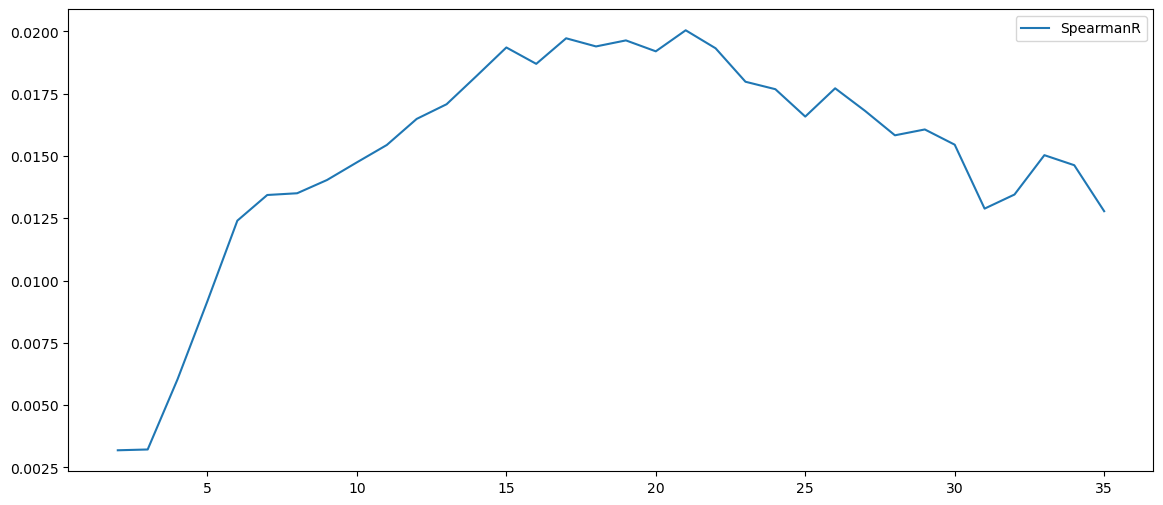

In [8]:
lag = 1
percentile_windows = range(2,36)

windows_dict = {}
for window in percentile_windows:
    
    factor_percentiles = pfh_factor_percentiles(SYNTHETIC_PRICE, window)

    factors_lagged = factor_percentiles.shift(lag)
    returns = RETURNS
    ts_spearmanr_df = cross_sectional_spearmanr(factors_lagged, returns).dropna()
    windows_dict[window] = ts_spearmanr_df["SpearmanR"].mean()

windows_df = pd.DataFrame.from_dict(windows_dict, orient="index", columns = ["SpearmanR"])
windows_df.plot(figsize = (14,6))
windows_df.sort_values(by = ["SpearmanR"], ascending=False).head(20).T

The Spearman correlation between returns and factor percentiles would suggest a rolling monthly window between 11 and 22. However, it is essential to note that increasing the window ignores part of the sample space. In this case, a 20+ month rolling window will completely ignore the Great Recession (2007-2009), which will make subsequent returns appear higher.     

EXAMINE RISK & RETURN MEASURES FOR OPTIMAL WINDOW

How different risk and return measures behave depends on the selected window. We will break the percentiles into five ranked quantiles and compare the return and risk stats for the quantiles.

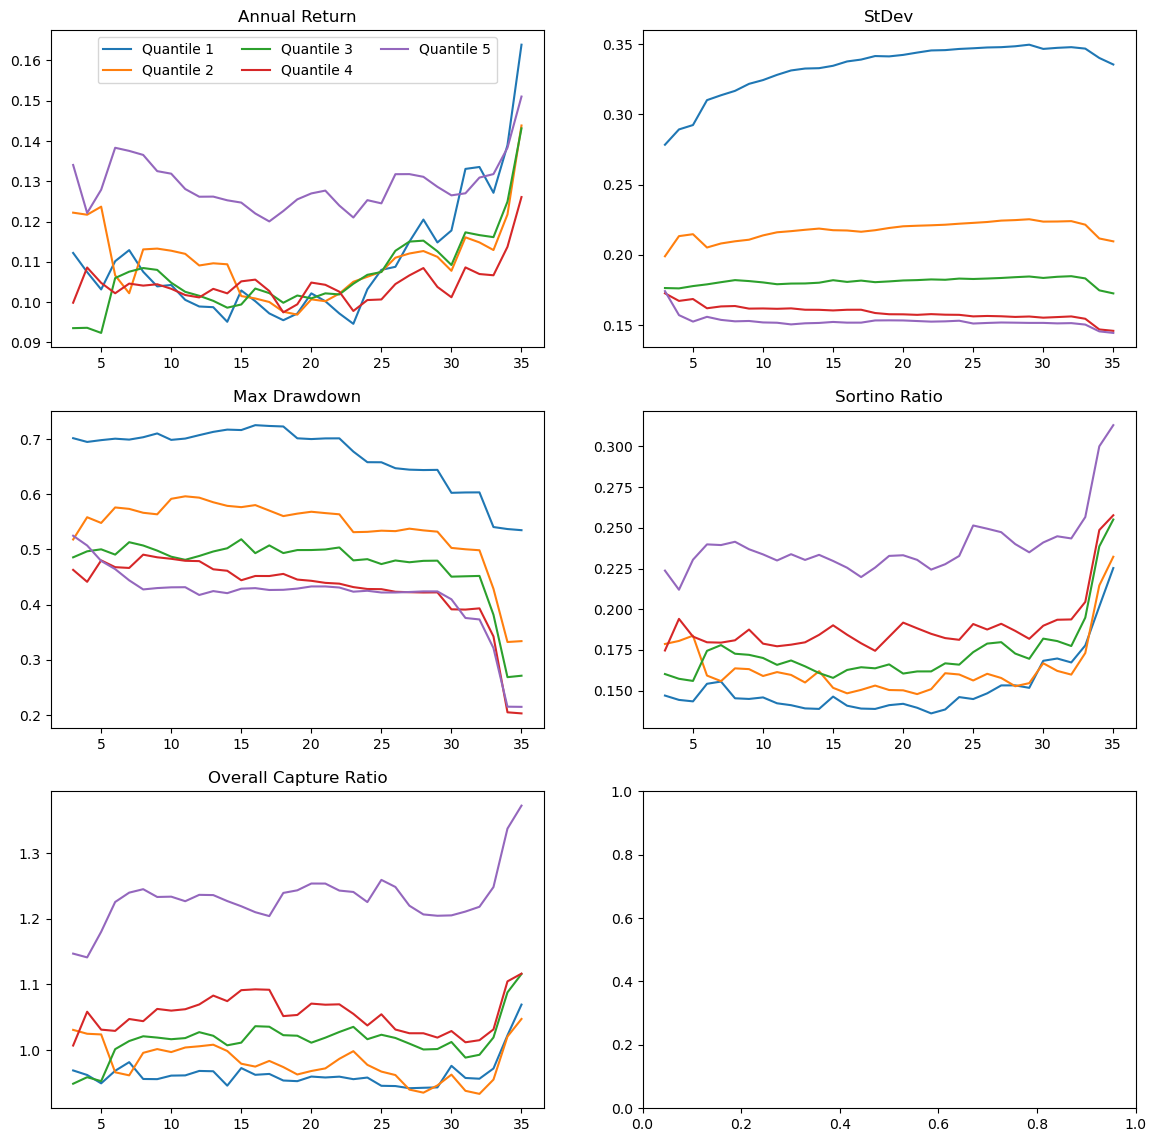

In [9]:
# Calculate Annual Return, Annual Standard Deviation, Max Drawdown, Sortino Ratio, and Overall Capture Ratio.
windows = range(3,36)
ar_dict = {}
sd_dict = {}
md_dict = {}
sr_dict = {}
cr_dict = {}
for window in windows:

    factor_percentiles = pfh_factor_percentiles(prices = SYNTHETIC_PRICE, window = window)
    factor_quantiles = quantiles_dataframe(factor_percentiles, quantiles = 5)
    quantile_returns = compute_quantile_returns(quantiles = factor_quantiles , returns = RETURNS, lag = 1)

    table = quantile_performance_table(quantile_returns, bk_returns = BK_PCT)

    ar_dict[window] = table.loc["Annual Return", :]
    sd_dict[window] = table.loc["Annual StDev", :]
    md_dict[window] = table.loc["Max Drawdown", :]
    sr_dict[window] = table.loc["Sortino Ratio", :]
    cr_dict[window] = table.loc["Capture Ratio", :]


# Plot the data
ar_df = pd.DataFrame(ar_dict).T
sd_df = pd.DataFrame(sd_dict).T
md_df = pd.DataFrame(md_dict).T
sr_df = pd.DataFrame(sr_dict).T
cr_df = pd.DataFrame(cr_dict).T

fig, ax = plt.subplots(3,2, figsize = (14,14))
ar_df.plot(ax = ax[0,0], title = "Annual Return")


sd_df.plot(ax = ax[0,1], legend=False, title = "StDev")
md_df.plot(ax = ax[1,0], legend=False, title = "Max Drawdown")
sr_df.plot(ax = ax[1,1], legend=False, title = "Sortino Ratio")
cr_df.plot(ax = ax[2,0], legend=False, title = "Overall Capture Ratio")

ax[0,0].legend(loc='upper center', ncols= 3, labels = ["Quantile 1", "Quantile 2", "Quantile 3", "Quantile 4", "Quantile 5"])
plt.show()

Given the risk and returns statistics, the monthly 11 to 22 window seems to perform well. For the purposes of this exercise, we will stick with a 12-month rolling window.

### QUANTILES ROLLING WINDOW BACKTEST

In the rolling window backtesting methodology, instead of dividing the data into only two samples, researchers typically use a rolling window (or walk-forward) framework, fit/calibrate factors or trade signals based on the rolling window, rebalance the portfolio periodically (i.e., after each period), and then track the performance over time. In this case, backtesting is a proxy for actual investing. As new information arrives, investment managers re-adjust their models and rebalance their stock positions.

Securities factor score percentiles are ranked and grouped into buckets. We compute each bucket's one-month forward return. 

Two breakdowns:
- 5 Quantiles
- 10 Quantiles

The below image is an example of using the earning yield factor, and a rolling window backtest

OOS: Out-of-Sample

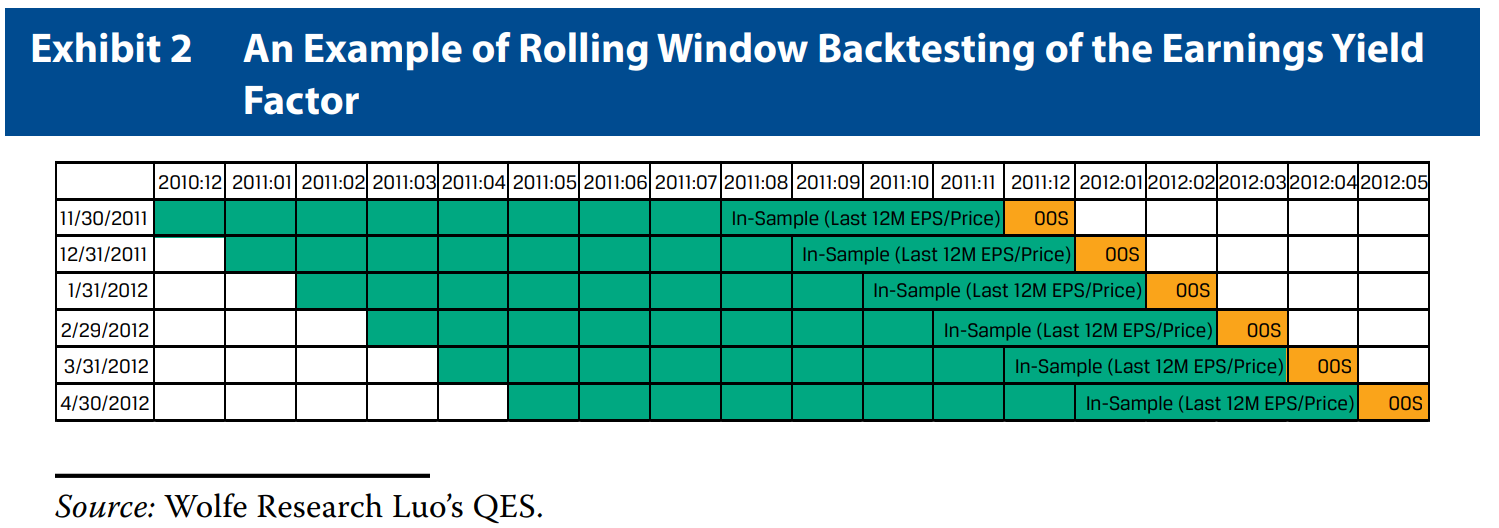

ASSIGN SECURITY FACTOR SCORES INTO QUANTILES:

In [10]:
QUANTILE_N5 = quantiles_dataframe(FACTOR_PFH_PERCENTILE, 5)
QUANTILE_N10 = quantiles_dataframe(FACTOR_PFH_PERCENTILE, 10)

As a sanity check, let's see how many securities are in each quantile.

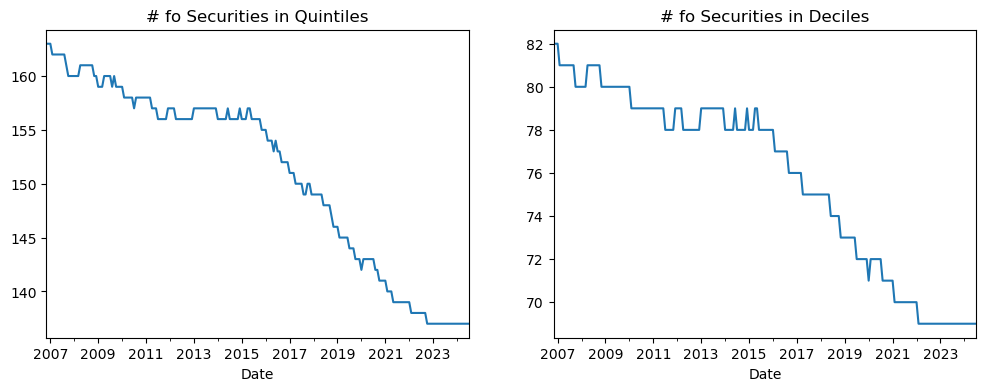

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

(QUANTILE_N5 == 1).sum(axis =1).plot(title = "# fo Securities in Quintiles", ax = ax[0])
(QUANTILE_N10 == 1).sum(axis =1).plot(title = "# fo Securities in Deciles",ax = ax[1])

plt.show()

We must shift the quartiles one period forward (n-1) and compute the different quantile returns.

Let's visualize the quantiles:

In [12]:
QUANTILE_N5_RETS = compute_quantile_returns(QUANTILE_N5, RETURNS, lag=1)
QUANTILE_N5_CUMRETS = (QUANTILE_N5_RETS+1).cumprod() - 1 
QUANTILE_N5_CUMRETS.iloc[[-1]]*100

,1,2,3,4,5
Date,,,,,
2024-07-31,429.238018,522.884359,452.310141,448.72499,715.78433


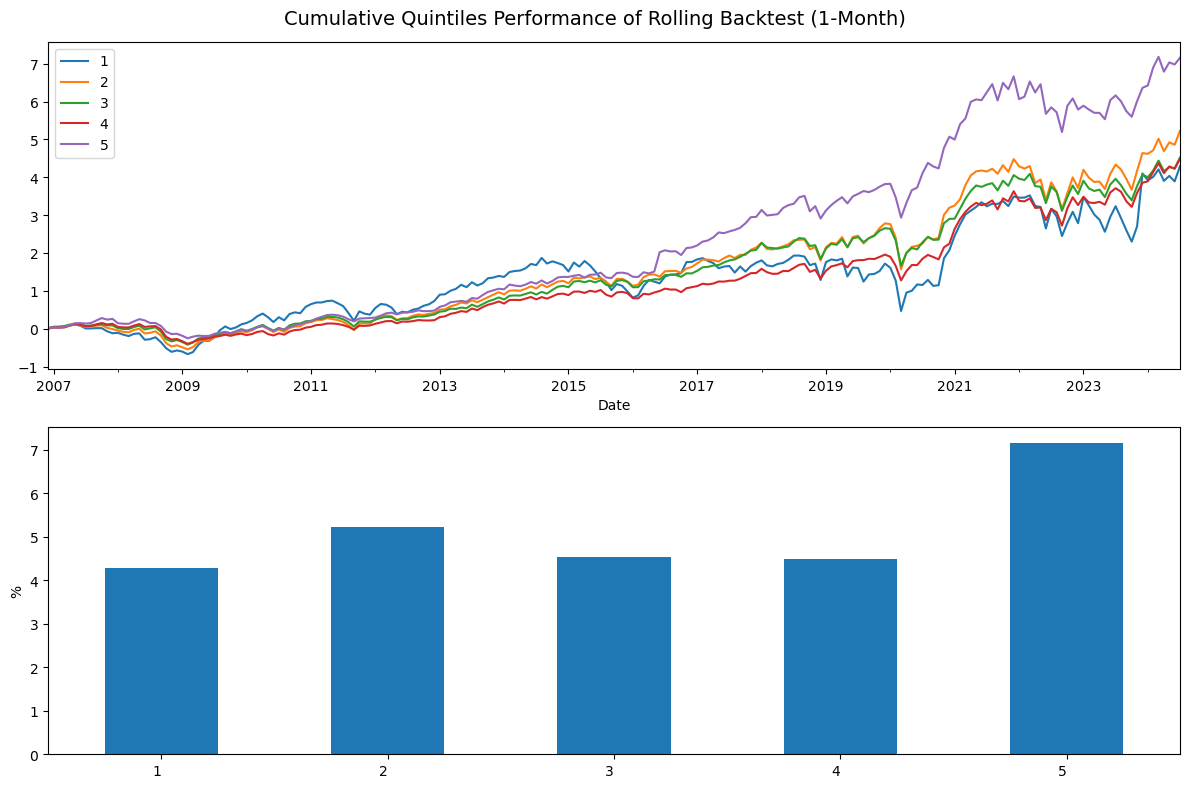

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
fig.suptitle("Cumulative Quintiles Performance of Rolling Backtest (1-Month)", fontsize=14)
QUANTILE_N5_CUMRETS.plot(ax = ax1)
QUANTILE_N5_CUMRETS.iloc[-1].plot(kind = "bar", ax = ax2, ylabel = "%")
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

The 5th Quintile (the securities with prices closer to their 12-month high) does seem to outperform. However, the other quintiles' cumulative returns are underwhelming. In an ideal situation, we would like to see a gradual drop in performance as we move from the 5th to the 1st quintile. Let's plot the deciles, too.

In [14]:
QUANTILE_N10_RETS = compute_quantile_returns(QUANTILE_N10, RETURNS, lag=1)
QUANTILE_N10_CUMRETS = (QUANTILE_N10_RETS+1).cumprod() - 1 
QUANTILE_N10_CUMRETS.iloc[[-1]] * 100

,1,2,3,4,5,6,7,8,9,10
Date,,,,,,,,,,
2024-07-31,526.414021,280.167698,524.387116,512.143967,460.279582,438.097771,367.748185,532.065009,634.565169,768.468351


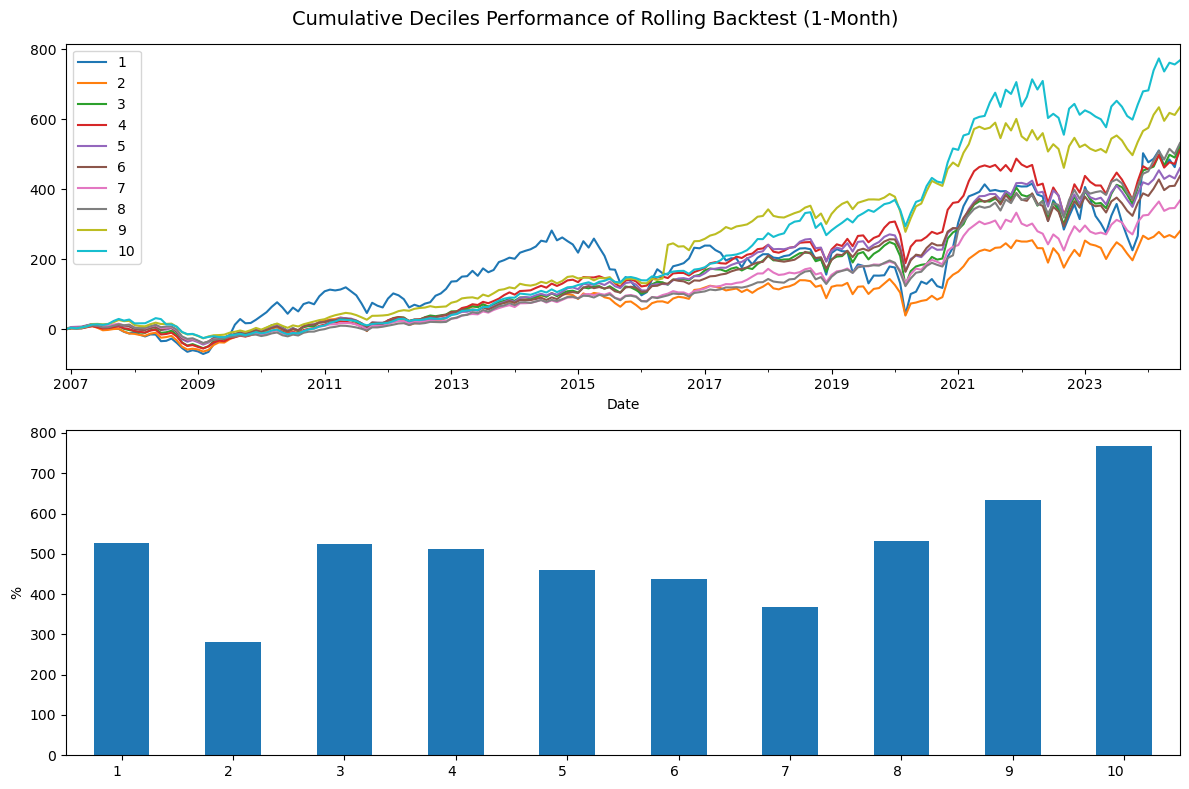

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
fig.suptitle("Cumulative Deciles Performance of Rolling Backtest (1-Month)", fontsize=14)
(QUANTILE_N10_CUMRETS*100).plot(ax = ax1)
(QUANTILE_N10_CUMRETS*100).iloc[-1].plot(kind = "bar", ax = ax2, ylabel = "%")
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

There is definitely a gradual drop in performance from 10 to 7 deciles, but the performance is mixed after that.

Let's compute some summary risk & return statistics and visualize them.

In [16]:
PERFORMANCE_TABLE_N5 = quantile_performance_table(QUANTILE_N5_RETS, BK_PCT) * 100
drawdowns = compute_drawdowns(QUANTILE_N5_RETS)
PERFORMANCE_TABLE_N5.columns = ["QUANTILE 1", "QUANTILE 2", "QUANTILE 3", "QUANTILE 4", "QUANTILE 5"]
PERFORMANCE_TABLE_N5

,QUANTILE 1,QUANTILE 2,QUANTILE 3,QUANTILE 4,QUANTILE 5
Annual Return,9.890811,10.908915,10.156559,10.115960,12.615613
Annual StDev,33.128594,21.687589,17.956133,16.190422,15.049561
Sharpe Ratio,29.855813,50.300269,56.563172,62.481137,83.827119
Sortino Ratio,14.103967,15.963922,16.851802,17.822142,23.380651
Max Drawdown,70.711619,59.389794,48.825381,47.891434,41.759351
Down Capture,160.915495,125.170922,104.609208,91.726819,79.408975
Up Capture,155.844270,125.922736,107.483505,98.112627,98.181291
Capture Ratio,96.848516,100.600630,102.747652,106.961767,123.640044


SUMMARY VISUALIZATION OF ROLLING BACKTEST

Let's put everything in one visual:

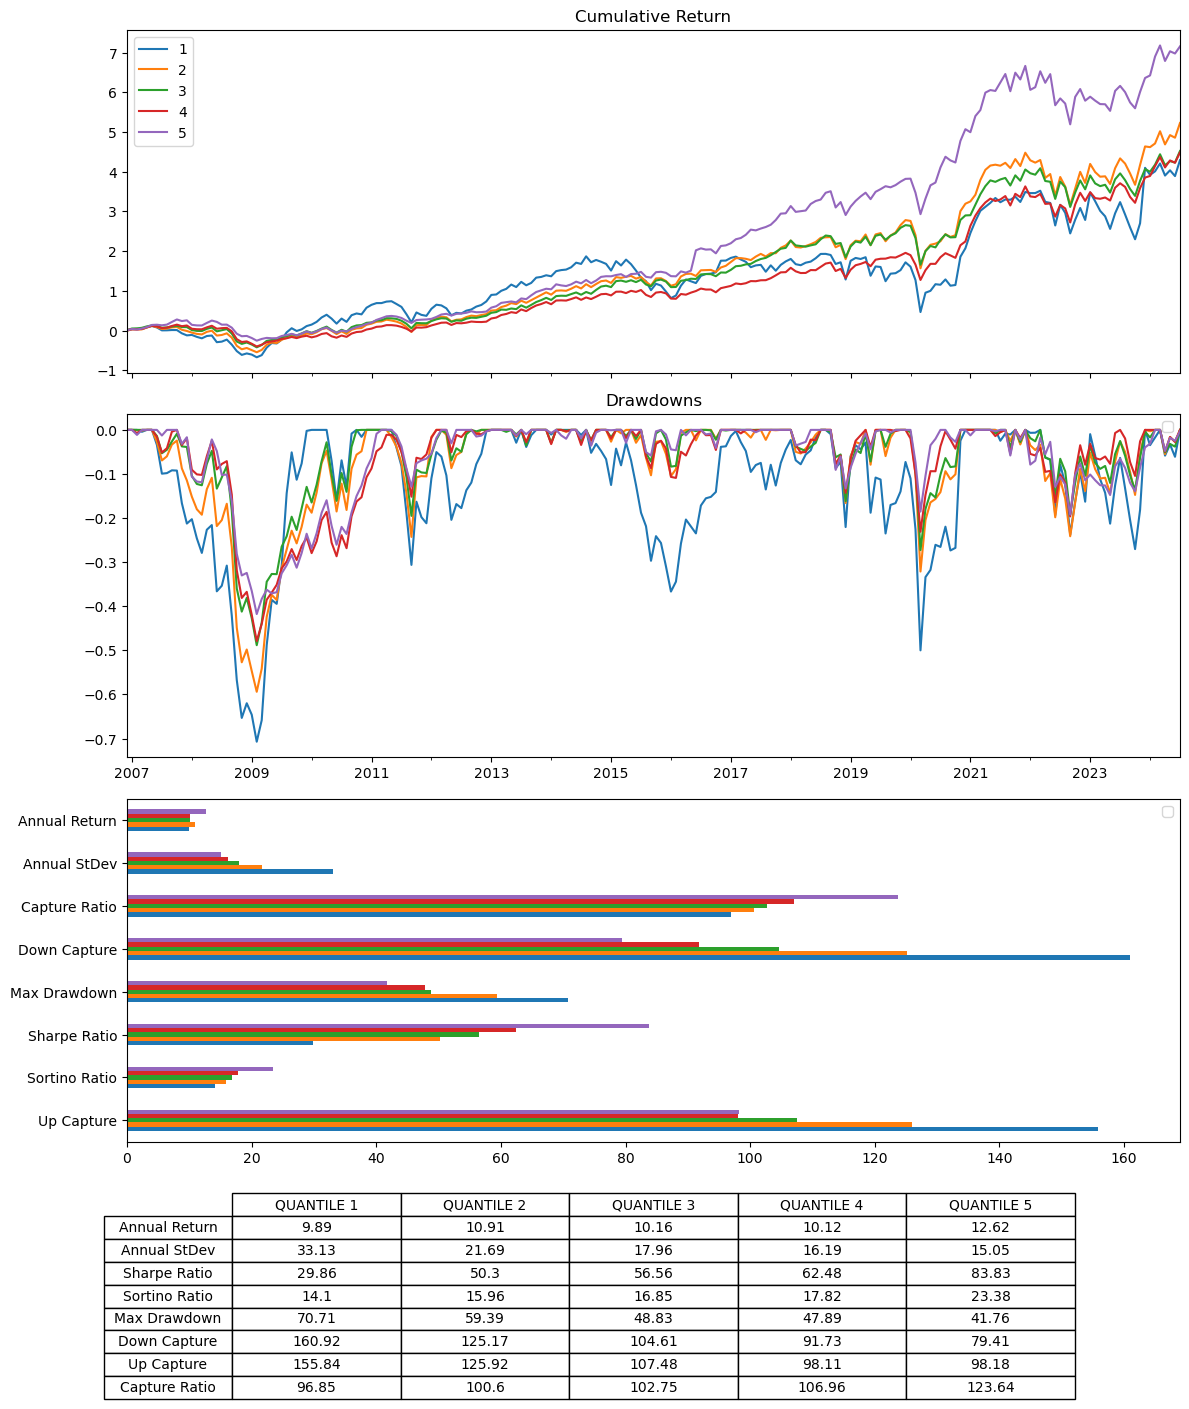

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(12, 14))

QUANTILE_N5_CUMRETS.plot(ax = ax[0], title = "Cumulative Return")
plt.legend(["QUANTILE 1", "QUANTILE 2", "QUANTILE 3", "QUANTILE 4", "QUANTILE 5"])
ax[0].set_xlabel('')
ax[0].set_xticklabels([])

drawdowns.plot(ax = ax[1], title= "Drawdowns")
ax[1].set_xlabel('')
ax[1].legend([])

PERFORMANCE_TABLE_N5.round(2).sort_index(ascending=False).plot.barh(ax=ax[2], legend = False)

ax[2].table(cellText=PERFORMANCE_TABLE_N5.values.round(2), colLabels=PERFORMANCE_TABLE_N5.columns, rowLabels=PERFORMANCE_TABLE_N5.index, loc="right", 
         bbox=[0.10, -0.75, 0.8, 0.60], colLoc = "center", rowLoc = "center", 
         cellLoc = "center")

plt.tight_layout()
plt.show()

All the risk measures improve as we move from the 1st quantile to the 5th. Although we cannot conclude that investing in securities trading closer to their 12-month high will improve returns, we can expect those securities to have a lower standard deviation, max drawdown, and down capture. This also translates into better risk-adjusted measures such as shape and sortino ratio.

### INFORMATION COEFFICIENT (IC): SPEARMAN RANK

The information coefficient (IC) is more commonly used than the hedged portfolio approach by practitioners as the standard metric of a factor’s predictive power for future stock returns. Since most quantitative models are linear, the IC approach captures the entire spectrum of stocks. This approach contrasts with the long/short quantile portfolio approach, which focuses only on quantiles. In the same manner, as the long/short hedged portfolio approach, the IC is also computed periodically—for example, monthly—following the rolling window backtesting and portfolio rebalancing methodology described previously. Spearman's correlation is less sensitive to outliers since it uses ranks rather than raw values, which can benefit financial data where extreme values are expected. Typically, investment managers are interested not only in the average IC over time but also in the stability or consistency of the IC.

Let's take a closer look at the Spearman correlation, its volatility, and risk-adjusted value:

In [18]:
lag = 1

FACTOR_PFH_PERCENTILE_S1M = FACTOR_PFH_PERCENTILE.shift(lag)
SRR_S1M = cross_sectional_spearmanr(FACTOR_PFH_PERCENTILE_S1M, RETURNS).dropna()

MEAN_1M = SRR_S1M.mean()
STD_1M = SRR_S1M.std()
RA_IC_1M = (MEAN_1M/STD_1M)

SPEARMANR_SUMMARY = pd.DataFrame([MEAN_1M, STD_1M, RA_IC_1M], index = ["Infomation Coefficient (IC)", "StDev", "Risk Adj IC"])
SPEARMANR_SUMMARY

,SpearmanR,P-Value
Infomation Coefficient (IC),0.016486,0.110076
StDev,0.220342,0.244051
Risk Adj IC,0.074818,0.451036


There appears to be a tiny positive relationship between securities whose prices trade closer to their 12-month high and their subsequent returns. Further, the p-value of the Spearman correlation coefficient does not show statistical significance at that level.   

#### CROSS-SECTIONAL (UNIVARIATE) REGRESSION

Next, we will perform cross-sectional (univariate) regression between the factor percentiles and their subsequent returns.

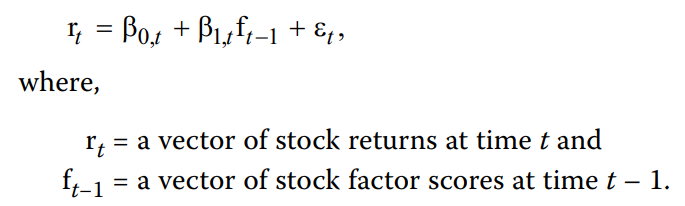

In [19]:
import statsmodels.api as sm

factors = FACTOR_PFH_PERCENTILE_S1M.dropna(how="all")
returns = RETURNS.dropna(how="all")

cross_unireg = {}
for date in factors.index:
    date_factors = factors.loc[date].dropna()
    date_returns = returns.loc[date].dropna()
    common_securities = np.intersect1d(date_returns.index, date_factors.index)

    Y = date_returns[common_securities]
    X = sm.add_constant(date_factors[common_securities])

    model = sm.OLS(Y, X).fit()

    coef = model.params[date]
    t_value = model.tvalues[date]
    p_value = model.pvalues[date]
    r_square = model.rsquared

    cross_unireg[date] = {"COEF": coef, "T_VALUE": t_value, "P_VALUE": p_value, "R_SQUARE": r_square}

cross_unireg_df = pd.DataFrame.from_dict(cross_unireg, orient="index")
cross_unireg_df

,COEF,T_VALUE,P_VALUE,R_SQUARE
2006-12-31,0.010956,1.563183,1.184002e-01,0.003008
2007-01-31,-0.011430,-1.390541,1.647475e-01,0.002387
2007-02-28,-0.023648,-3.240901,1.240372e-03,0.012848
2007-03-31,0.036016,5.038513,5.797123e-07,0.030609
2007-04-30,-0.014816,-1.769925,7.711817e-02,0.003876
...,...,...,...,...
2024-03-31,-0.006918,-0.674322,5.003360e-01,0.000668
2024-04-30,0.016235,1.543369,1.232064e-01,0.003491
2024-05-31,0.000846,0.060828,9.515144e-01,0.000005
2024-06-30,0.023292,2.325786,2.032359e-02,0.007904


Let's visualize the coefficient through time: 

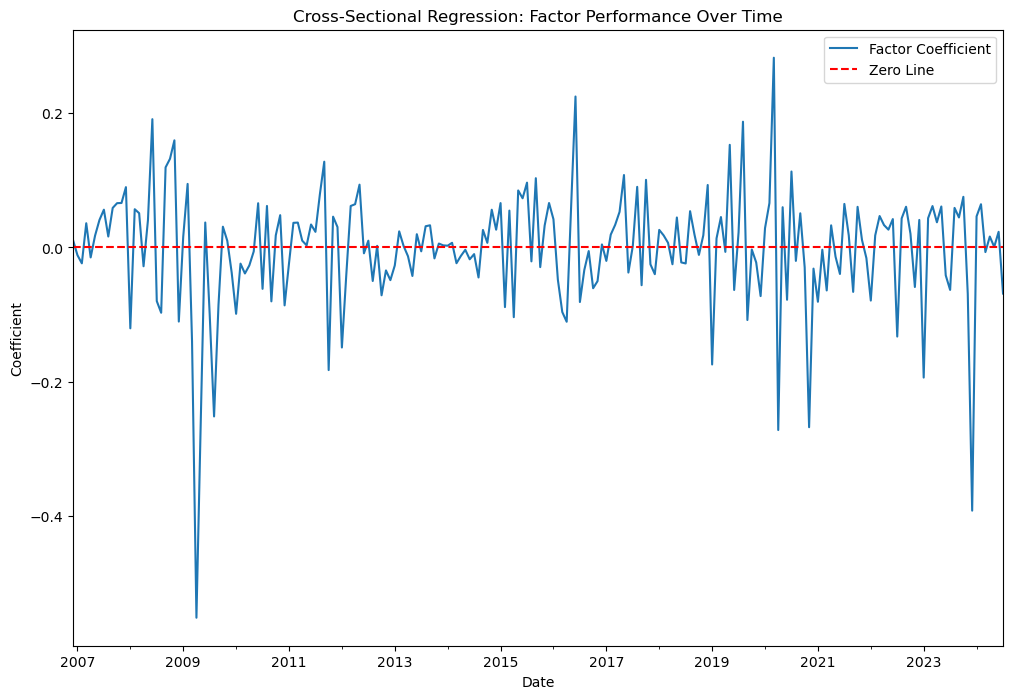

Mean Coefficient: -0.0024
Median Coefficient: 0.0084
P-Value: 0.0001
Proportion of Positive Coefficients: 0.5566
Average R-squared: 0.0415


In [20]:
cross_unireg_df["COEF"].plot(title = 'Cross-Sectional Regression: Factor Performance Over Time', figsize=(12,8), label='Factor Coefficient')

plt.axhline(y=0, color='r', linestyle='--', label='Zero Line')
plt.xlabel('Date')
plt.ylabel('Coefficient')
plt.legend()
plt.show()

# Summary statistics
print(f"Mean Coefficient: {cross_unireg_df['COEF'].mean():.4f}")
print(f"Median Coefficient: {cross_unireg_df['COEF'].median():.4f}")
print(f"P-Value: {cross_unireg_df['P_VALUE'].median():.4f}")
print(f"Proportion of Positive Coefficients: {sum(cross_unireg_df['COEF'] > 0) / len(cross_unireg_df):.4f}")
print(f"Average R-squared: {cross_unireg_df['R_SQUARE'].mean():.4f}")

The mean coefficient is slightly negative, while the median is slightly positive, suggesting that the factor does not improve performance.

### FACTOR TURNOVER AND DECAY

When evaluating the backtest of an investment strategy, one must consider the turnover rate because it significantly impacts the feasibility and profitability of the approach due to associated transaction costs. Signal autocorrelation (i.e., serial correlation) is commonly used to measure factor turnover and isolate factor changes' effect from portfolio construction. Signal autocorrelation is computed as the correlation between the vector of today’s (t) factor scores and the factor scores from the preceding period (t – 1):

Signal Autocorrelation = Correlation(Ft, Ft-1), where Ft is the vector of factor scores as of time t. 

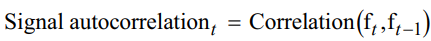

The signal autocorrelation is then plotted over time. Assuming the identified factors produce strong excess return, all else being equal, factors with low turnover, indicated by high autocorrelation, are preferred because such factors lead to lower portfolio turnover, lower transaction costs, and, therefore, higher after-cost cumulative performance.

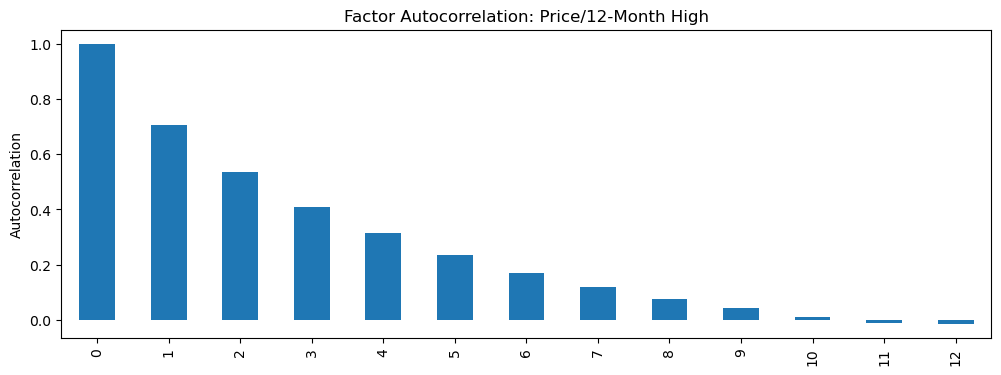

In [21]:
from statsmodels.tsa.stattools import acf

factors = factors.dropna(how="all")
lags = 12

acf_dict = {}
qstat_dict = {}
pvalue_dict = {}
for security in factors.columns:

    factor = factors[security].dropna()

    if factor.empty | factor.shape[0] < 3:
        continue

    else:
        acf_values, qstat, p_value = acf(factor, nlags=lags, qstat = True)
        acf_dict[security] = acf_values
        qstat_dict[security] = qstat
        pvalue_dict[security] = p_value

acf_df = pd.DataFrame.from_dict(acf_dict, orient = "index").T
qstat_df = pd.DataFrame.from_dict(qstat_dict, orient = "index").T
pvalue_df = pd.DataFrame.from_dict(pvalue_dict, orient = "index").T

factor_turnover = pd.concat([acf_df.mean(axis=1), qstat_df.mean(axis=1), pvalue_df.mean(axis=1)], axis = 1)
factor_turnover.columns = ["Mean ACF", "Q_Stat", "QP_Value"]

factor_turnover["Mean ACF"].plot.bar(title = "Factor Autocorrelation: Price/12-Month High", ylabel = "Autocorrelation", figsize = (12,4))
plt.show()

Given that the autocorrelation disappears by ten months, we can expect that the factor will likely be a pretty high turnover.

Next, we will measure the decay of information in the factor. This will help us measure the decline in a factor’s predictive power as the forecasting horizon (or backtesting history) is extended. Information decay is proxied by computing the Spearman rank IC between factor scores in the x months before the factor measurement date and the current month’s stock returns.

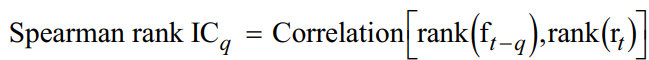

In [22]:
returns = RETURNS.dropna(how="all")
factors = FACTOR_PFH_PERCENTILE
max_lag = 16

factor_decay_corr = {}
for q in range(1, max_lag + 1):
    factors_lagged = factors.shift(q)
    spearmanR = cross_sectional_spearmanr(factors_lagged, returns).dropna().mean()

    factor_decay_corr[q] = [spearmanR["SpearmanR"], spearmanR["P-Value"]]

factor_decay = pd.DataFrame.from_dict(factor_decay_corr, orient="index", columns = ["SpearmanR", "P-Value"])

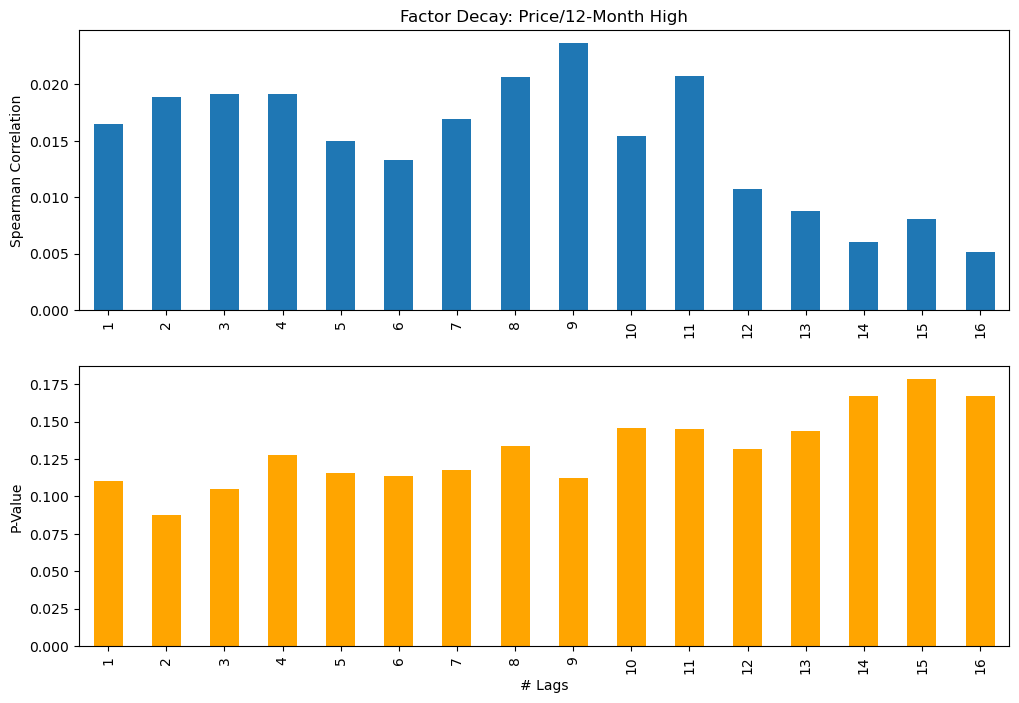

In [23]:
fig, ax = plt.subplots(2,1, figsize = (12,8))

(factor_decay["SpearmanR"]).plot.bar(ax = ax[0], title = "Factor Decay: Price/12-Month High", ylabel = "Spearman Correlation")
(factor_decay["P-Value"]).plot.bar(ax = ax[1], xlabel = "# Lags", ylabel = "P-Value", color="orange")
plt.show()

The factor appears to decay after the 11th month.

This analysis indicates that the Price/Price 12-month High will likely improve risk-adjusted returns but not absolute returns. Further, the strategy could be too costly to implement given the high factor turnover and relatively quick factor decay.